In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

## Prefixspan

In [54]:
pfs = pd.read_csv("inputprefixspan.csv")

#### Change the column names because XGBoost does not accept [] or ,


In [55]:
pfs.columns = ['usersession', 'sequences', '2', '22', '222', '2222', '22222', 'target']

#### Implementing XGBoost

In [56]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [132]:
X1 = pfs.drop(columns = ['target', 'usersession', 'sequences'])
y1 = pfs['target']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.3, random_state = 0)

In [133]:
print(X1.shape)
print(y1.shape)

(488374, 5)
(488374,)


In [134]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Frequency')

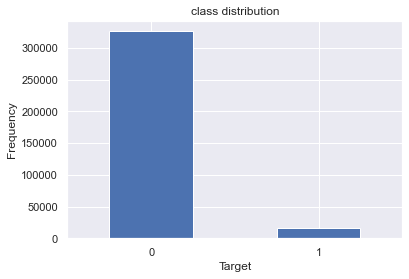

In [135]:
count_classes = pd.value_counts(y_train1, sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('class distribution')
plt.xticks(range(2))
plt.xlabel('Target')
plt.ylabel('Frequency')

In [136]:
Class = [len(y_train1.loc[y_train1 == 1]), len(y_train1.loc[y_train1 == 0])]
pd.Series(Class, index = ['Purchase', 'No-Purchase'], name = 'target')

Purchase        15689
No-Purchase    326172
Name: target, dtype: int64

In [61]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [128]:
undersample = RandomUnderSampler()

In [129]:
X_train1, y_train1 = undersample.fit_resample(X_train1, y_train1)

In [130]:
Class = [len(y_train1.loc[y_train1 == 1]), len(y_train1.loc[y_train1 == 0])]
pd.Series(Class, index = ['Purchase', 'No-Purchase'], name = 'target')

Purchase       15689
No-Purchase    15689
Name: target, dtype: int64

Text(0, 0.5, 'Frequency')

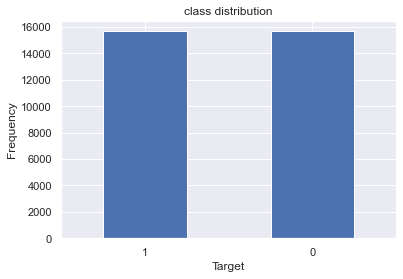

In [131]:
count_classes = pd.value_counts(y_train1, sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('class distribution')
plt.xticks(range(2))
plt.xlabel('Target')
plt.ylabel('Frequency')

In [65]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

In [66]:
# initialize domain range:
space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0 
    }

In [67]:
# define objective function
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), use_label_encoder=False)
    
    evaluation = [( X_train1, y_train1.values.ravel()), ( X_test1, y_test1.values.ravel())]
    
    clf.fit(X_train1, y_train1.values.ravel(),
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test1)
    acc = accuracy_score(y_test1, pred)
    print ("SCORE:", acc)
    return {'loss': -acc, 'status': STATUS_OK }

In [69]:
# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9316033389528574                                     
SCORE:                                                                            
0.9160620559267778                                                                
SCORE:                                                                            
0.9160620559267778                                                                
SCORE:                                                                            
0.9160620559267778                                                                
SCORE:                                                                            
0.9160620559267778                                                                
SCORE:                                                                            
0.9160620559267778                                                                
SCORE:                                                    

In [70]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6273555818987049, 'gamma': 4.853856993952946, 'max_depth': 14.0, 'min_child_weight': 8.0, 'reg_alpha': 160.0, 'reg_lambda': 0.3848753293685958}


In [71]:
train1 = xgb.DMatrix(X_train1, label = y_train1)
test1 = xgb.DMatrix(X_test1, label = y_test1)

In [72]:
param1 = { 'colsample_bytree': 0.6273555818987049,
          'gamma': 4.853856993952946, 
          'max_depth': 14, 
          'min_child_weight': 8.0, 
          'reg_alpha': 160.0, 
          'reg_lambda': 0.3848753293685958,
          'objective': 'multi:softmax',
            'num_class': 2,
             'eta': 0.1,
             'eval_metric':'mlogloss'}
epochs = 10

In [73]:
model1 = xgb.train(param1, train1, epochs)

In [74]:
y_pred1 = model1.predict(test1)

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

print(confusion_matrix(y_test1, y_pred1))
print('precision:', metrics.precision_score(y_test1, y_pred1))
print('recall:', metrics.recall_score(y_test1, y_pred1))
print("Accuracy:",metrics.accuracy_score(y_test1, y_pred1))
print("f1-score micro:",metrics.f1_score(y_test1, y_pred1))

[[130240   9642]
 [  2656   3975]]
precision: 0.29191451861643536
recall: 0.5994570954607148
Accuracy: 0.9160620559267778
f1-score micro: 0.39263137099960493


## ClaSP

In [78]:
clasp = pd.read_csv('inputclasp.csv')

In [79]:
clasp.columns = ['usersession', 'sequences', '2', '22', '222', '0', '20', 'target']

In [80]:
X2 = clasp.drop(columns = ['target', 'usersession', 'sequences'])
y2 = clasp['target']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.3, random_state = 0)

Text(0, 0.5, 'frequency')

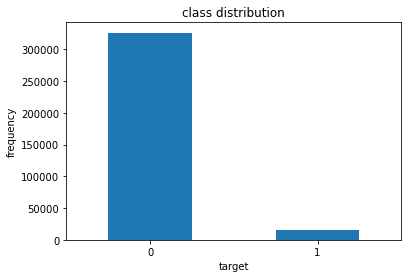

In [81]:
count_classes = pd.value_counts(y_train2, sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('class distribution')
plt.xticks(range(2))
plt.xlabel('target')
plt.ylabel('frequency')

In [82]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [83]:
X_train2, y_train2 = undersample.fit_resample(X_train2, y_train2)

In [84]:
Class = [len(y_train1.loc[y_train1 == 1]), len(y_train1.loc[y_train1 == 0])]
pd.Series(Class, index = ['Purchase', 'No-Purchase'], name = 'target')

Purchase       15689
No-Purchase    15689
Name: target, dtype: int64

Text(0, 0.5, 'frequency')

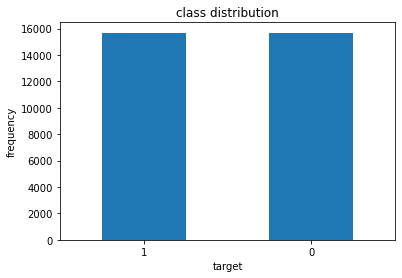

In [85]:
count_classes = pd.value_counts(y_train2, sort = True)
count_classes.plot(kind = 'bar', rot = 0)
plt.title('class distribution')
plt.xticks(range(2))
plt.xlabel('target')
plt.ylabel('frequency')

In [86]:
# initialize domain range:
space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0 
    }

In [87]:
# define objective function
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), use_label_encoder=False)
    
    evaluation = [( X_train2, y_train2.values.ravel()), ( X_test2, y_test2.values.ravel())]
    
    clf.fit(X_train2, y_train2.values.ravel(),
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test2)
    acc = accuracy_score(y_test2, pred)
    print ("SCORE:", acc)
    return {'loss': -acc, 'status': STATUS_OK }

In [88]:
# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9548572481622791                                     
SCORE:                                                                            
0.9548572481622791                                                                
SCORE:                                                                            
0.9548572481622791                                                                
SCORE:                                                                            
0.9548572481622791                                                                
SCORE:                                                                            
0.9548572481622791                                                                
SCORE:                                                                            
0.9548572481622791                                                                
SCORE:                                                    

In [89]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.7865494810673204, 'gamma': 1.0903410905350368, 'max_depth': 12.0, 'min_child_weight': 3.0, 'reg_alpha': 143.0, 'reg_lambda': 0.6293001779487499}


In [90]:
train2 = xgb.DMatrix(X_train2, label = y_train2)
test2 = xgb.DMatrix(X_test2, label = y_test2)

In [91]:
param2 = { 'colsample_bytree': 0.7865494810673204,
          'gamma': 1.0903410905350368, 
          'max_depth': 12, 
          'min_child_weight': 3.0, 
          'reg_alpha': 143.0, 
          'reg_lambda': 0.6293001779487499,
          'objective': 'multi:softmax',
        'num_class': 2,
         'eta': 0.1,
         'eval_metric':'mlogloss'}
epochs = 10

In [92]:
model2 = xgb.train(param2, train2, epochs)

In [93]:
y_pred2 = model2.predict(test2)

In [95]:
from sklearn import metrics
print(confusion_matrix(y_test2, y_pred2))
print('precision:', metrics.precision_score(y_test2, y_pred2))
print('recall:', metrics.recall_score(y_test2, y_pred2))
print("Accuracy:",metrics.accuracy_score(y_test2, y_pred2))
print("f1-score micro:",metrics.f1_score(y_test2, y_pred2))

[[136374   3508]
 [  3106   3525]]
precision: 0.5012085880847433
recall: 0.5315940280500678
Accuracy: 0.9548572481622791
f1-score micro: 0.5159543325526932


## VMSP

In [96]:
vmsp = pd.read_csv('inputvmsp.csv')

In [97]:
vmsp.columns = ['usersession', 'sequences', '2022', '2202', '222222', 'target']

In [98]:
Class = [len(vmsp.loc[vmsp.target == 1]), len(vmsp.loc[vmsp.target == 0])]
pd.Series(Class, index = ['Purchase', 'No-Purchase'], name = 'target')

Purchase        22320
No-Purchase    466054
Name: target, dtype: int64

In [99]:
X3 = vmsp.drop(columns = ['target', 'usersession', 'sequences'])
y3 = vmsp['target']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size = 0.3, random_state = 0)

In [100]:
X_train3, y_train3 = undersample.fit_resample(X_train3, y_train3)

In [101]:
# initialize domain range:
space ={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0 
    }

In [102]:
# define objective function
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']), use_label_encoder=False)
    
    evaluation = [( X_train3, y_train3.values.ravel()), ( X_test3, y_test3.values.ravel())]
    
    clf.fit(X_train3, y_train3.values.ravel(),
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test3)
    acc = accuracy_score(y_test3, pred)
    print ("SCORE:", acc)
    return {'loss': -acc, 'status': STATUS_OK }

In [103]:
# optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.9404080184010976                                     
SCORE:                                                                            
0.9555329561199347                                                                
SCORE:                                                                            
0.9555329561199347                                                                
SCORE:                                                                            
0.9555329561199347                                                                
SCORE:                                                                            
0.9404080184010976                                                                
SCORE:                                                                            
0.9404080184010976                                                                
SCORE:                                                    

In [104]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5977198838303659, 'gamma': 8.722979559052291, 'max_depth': 15.0, 'min_child_weight': 6.0, 'reg_alpha': 150.0, 'reg_lambda': 0.07685696468508751}


In [105]:
train3 = xgb.DMatrix(X_train3, label = y_train3)
test3 = xgb.DMatrix(X_test3, label = y_test3)

In [106]:
param3 = { 'colsample_bytree':  0.5977198838303659,
          'gamma': 8.722979559052291, 
          'max_depth': 15, 
          'min_child_weight': 6.0, 
          'reg_alpha': 150.0, 
          'reg_lambda': 0.07685696468508751,
          'objective': 'multi:softmax',
          'num_class': 2,
         'eta': 0.1,
         'eval_metric':'mlogloss'}
epochs = 10

In [107]:
model3 = xgb.train(param3, train3, epochs)

In [108]:
y_pred3 = model3.predict(test3)

In [109]:
from sklearn import metrics
print(confusion_matrix(y_test3, y_pred3))
print("accuracy-score:",metrics.accuracy_score(y_test3, y_pred3))
print('precision:', metrics.precision_score(y_test3, y_pred3))
print('recall:', metrics.recall_score(y_test3, y_pred3))
print("f1-score micro:",metrics.f1_score(y_test3, y_pred3))

[[138370   1512]
 [  5003   1628]]
accuracy-score: 0.9555329561199347
precision: 0.5184713375796178
recall: 0.2455134972100739
f1-score micro: 0.33323098966328935


#### Check which features has the highest importance and make a new model with those features

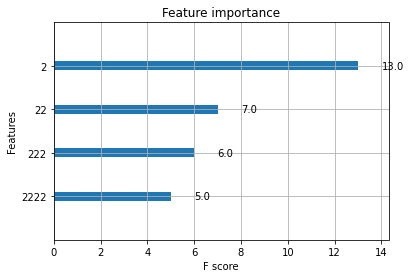

<Figure size 1152x864 with 0 Axes>

In [110]:
import matplotlib.pyplot as plt  # for plotting facilitie
xgb.plot_importance(model1)
plt.figure(figsize = (16, 12))
plt.show()

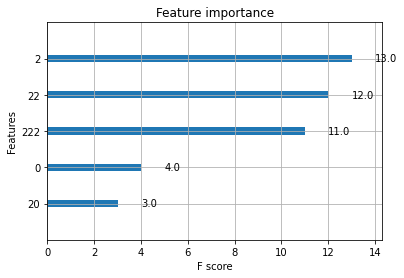

<Figure size 1152x864 with 0 Axes>

In [112]:
import matplotlib.pyplot as plt  # for plotting facilitie
xgb.plot_importance(model2)
plt.figure(figsize = (16, 12))
plt.show()

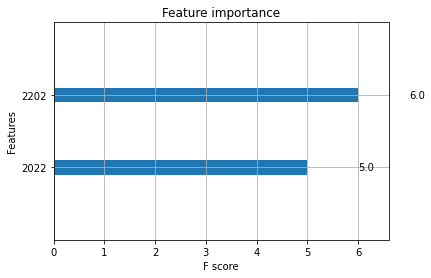

<Figure size 1152x864 with 0 Axes>

In [115]:
import matplotlib.pyplot as plt  # for plotting facilitie
xgb.plot_importance(model3)
plt.figure(figsize = (16, 12))
plt.show()

## Visualizations

In [116]:
def confusio_matrix(y_test, y_predicted):
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(5,5))
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
  
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [117]:
import seaborn as sns
sns.set()

Text(0.5, 12.5, 'Predicted label')

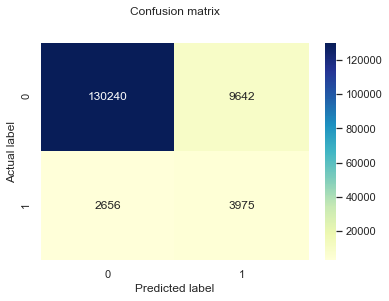

In [119]:
##PrefixSpan
cnf_matrix = metrics.confusion_matrix(y_test1, y_pred1)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 12.5, 'Predicted label')

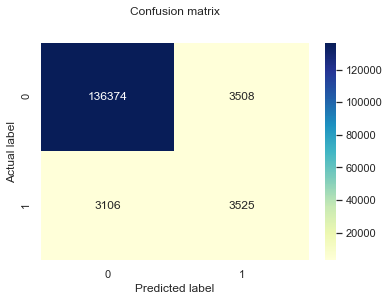

In [120]:
##ClaSp
cnf_matrix = metrics.confusion_matrix(y_test2, y_pred2)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 12.5, 'Predicted label')

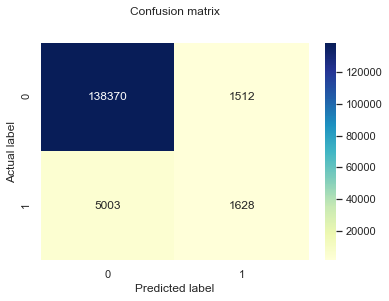

In [121]:
##VMSP
cnf_matrix = metrics.confusion_matrix(y_test3, y_pred3)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')